In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥1.0.2 is required
import sklearn
assert sklearn.__version__ >= "1.0.2"

# Common imports
import numpy as np
import os
import pandas as pd
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)


# Load and process data

In [3]:
# read data from csv file
trainset = pd.read_csv('../datasets/dataset_MonteCarlo_100.000/trainset.csv')
testset = pd.read_csv('../datasets/dataset_MonteCarlo_100.000/testset.csv')
print(trainset.shape)
print(testset.shape)

(80000, 15)
(20000, 15)


In [4]:
trainset

,0_Ca,0_Cl,0_Na,0_K,0_N5,1_Ca,1_Cl,1_Na,1_K,1_N5,out_Ca,out_Cl,out_Na,out_K,out_N5
0,0.341575,1.159034,0.012636,0.451710,0.794808,0.347226,0.116634,0.755911,0.674340,1.359338,0.3233,1.1590,0.02901,0.4719,0.79480
1,0.638607,0.558054,1.231009,0.243433,1.132821,0.038278,0.185744,0.734268,1.464984,1.489907,0.4584,0.5581,1.24700,0.5882,1.13300
2,0.787981,0.763241,0.349968,0.738449,1.452716,1.117356,0.110285,0.393380,0.282715,1.466671,0.8053,0.7632,0.34980,0.7038,1.45300
3,0.466115,0.948450,0.942671,1.051085,1.358636,0.470234,0.252135,0.914662,1.318543,1.076570,0.4558,0.9484,0.94180,1.0730,1.35900
4,0.452663,0.644895,1.360873,0.991130,0.162887,1.361588,1.475943,0.637112,0.397679,1.414160,0.4939,0.6449,1.34300,0.9266,0.16290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.796601,0.398041,1.132371,0.996845,0.094560,1.074895,1.055513,0.777877,0.870241,0.361988,0.8083,0.3980,1.12600,0.9802,0.09456
79996,0.942419,1.456538,1.164360,0.775981,0.069458,1.024540,1.025283,0.144121,1.438743,0.241862,0.9305,1.4570,1.15000,0.8141,0.06946
79997,1.095302,0.438446,1.335379,0.365207,0.273701,0.765942,0.880543,1.152310,1.119219,1.104459,1.0670,0.4384,1.33500,0.4223,0.27370
79998,0.310626,0.661302,0.192742,1.280823,0.931653,0.199012,0.072267,0.870017,0.563615,0.006399,0.3275,0.6613,0.21380,1.2260,0.93170


In [5]:
trainset['out_Ca_dif'] = trainset['out_Ca']-trainset['0_Ca']
trainset['out_Na_dif'] = trainset['out_Na']-trainset['0_Na']
trainset['out_K_dif'] = trainset['out_K']-trainset['0_K']

In [6]:
testset['out_Ca_dif'] = testset['out_Ca']-testset['0_Ca']
testset['out_Na_dif'] = testset['out_Na']-testset['0_Na']
testset['out_K_dif'] = testset['out_K']-testset['0_K']

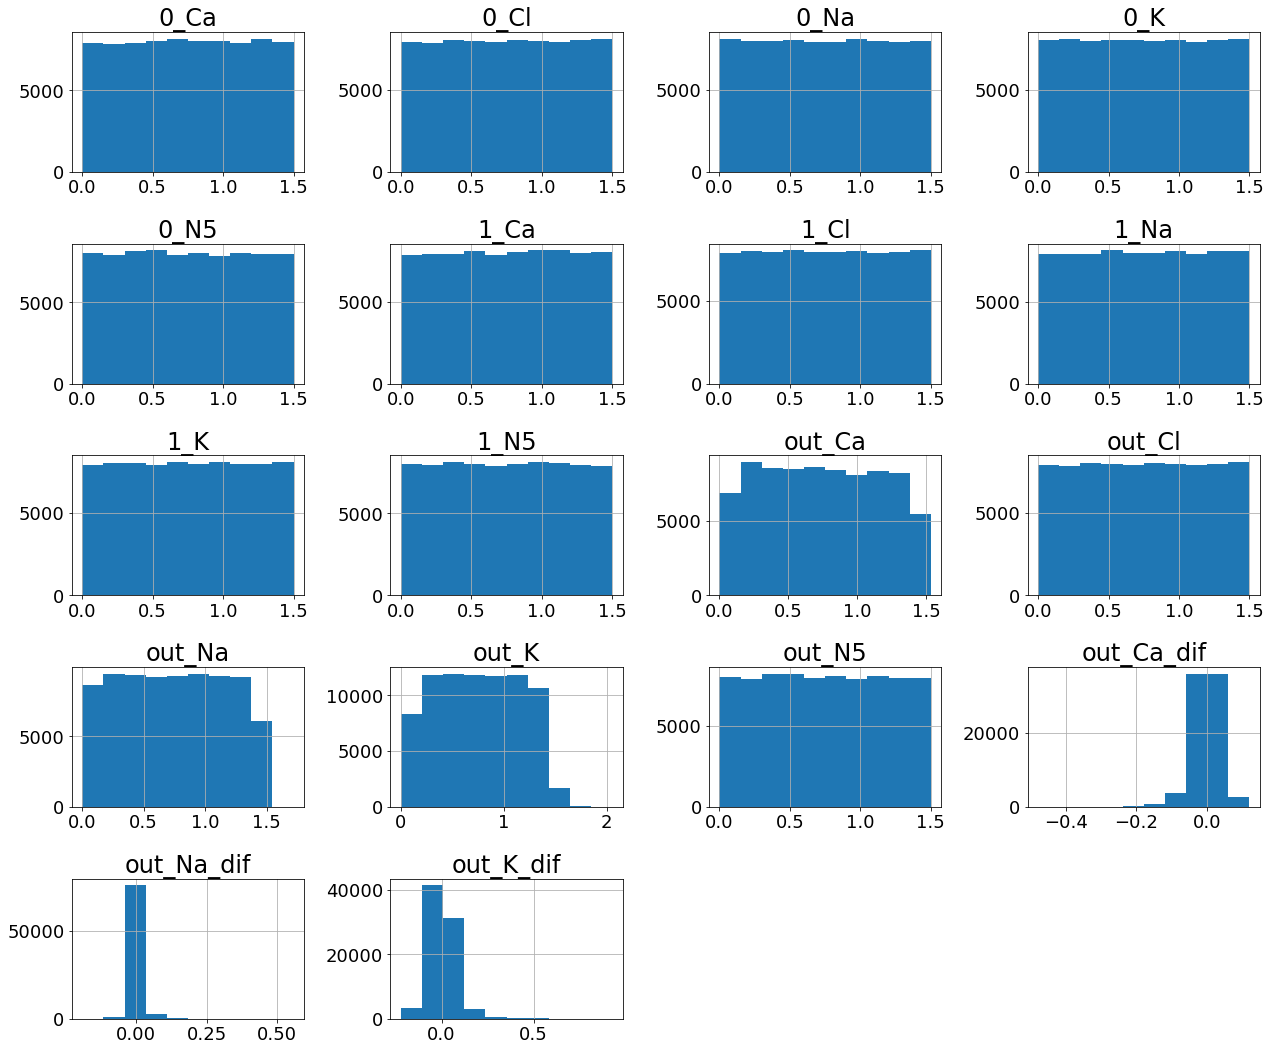

In [7]:
trainset.hist(figsize=(18, 15));
plt.tight_layout()

In [8]:
# split x and y
X_train = trainset.iloc[:, [0,2,3,5,7,8]].values 
y_train = trainset.iloc[:, [15, 16, 17]].values
X_test = testset.iloc[:, [0,2,3,5,7,8]].values 
y_test = testset.iloc[:, [15, 16, 17]].values

# Name variables
inputs = [list(trainset)[i] for i in [0,2,3,5,7,8]] 
outputs = [list(trainset)[i] for i in [15, 16, 17]] # do not work for list -> list(trainset)[10, 12, 13]

In [9]:
print('Inputs: ', inputs)
print('Outputs: ', outputs)
print('X_train instances: ', X_train.shape)
print('X_test instances: ', X_test.shape)
print('y_train instances: ', y_train.shape)
print('y_test instances: ', y_test.shape)

Inputs:  ['0_Ca', '0_Na', '0_K', '1_Ca', '1_Na', '1_K']
Outputs:  ['out_Ca_dif', 'out_Na_dif', 'out_K_dif']
X_train instances:  (80000, 6)
X_test instances:  (20000, 6)
y_train instances:  (80000, 3)
y_test instances:  (20000, 3)


## Normalize data

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

norm_pipeline = Pipeline([
        ('minmax_scaler', MinMaxScaler((-1,1))),
    ])

X_train_norm = norm_pipeline.fit_transform(X_train)
X_test_norm = norm_pipeline.transform(X_test)

# Fine Tuning

## Tensorflow NN

In [11]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam

print(tf.__version__)

2.4.1


In [12]:
INPUT_SIZE = 6
OUTPUT_SIZE = 3

# Model
def create_model(hiden_layers, neurons, dropout, kreg, activation, lactivation, lr):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(INPUT_SIZE,), activation=activation, kernel_regularizer=l2(kreg)))
    if dropout >1e-3:
        model.add(Dropout(dropout))
    for i in range(hiden_layers):
        model.add(Dense(neurons, activation=activation, kernel_regularizer=l2(kreg)))
        if dropout >1e-3:
            model.add(Dropout(dropout))
    model.add(Dense(OUTPUT_SIZE, activation=lactivation))

    model.compile(loss='mean_squared_error',
                  optimizer= Adam(lr), # rmsprop, adam, sgd, adagrad
                  metrics=['mean_squared_error'])
    return model

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=1000,
                                               verbose=10,
                                               restore_best_weights=True)

### No PINN

In [13]:
# for reproducibility
tf.random.set_seed(42) 
np.random.seed(42)

start = time.time()
# hiden_layers, neurons, dropout, kreg, activation, lactivation, lr, pinn_weight
#
# Best from Gridsearch_NeuralNetwork
#
model = create_model(1,256,0.0,1e-6,'relu','linear',1e-4)

history = model.fit(X_train_norm, 
          y_train, 
          epochs=1000, 
          batch_size=128,
          validation_split=0.2,
          callbacks = [early_stopping]
                   )

reg_best = model
print('\n\nTime: ',time.time()-start)

Epoch 1/1000


2023-10-11 12:20:02.437570: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-10-11 12:20:02.437851: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 12:20:02.447945: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-10-11 12:20:02.541797: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-10-11 12:20:02.559061: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2350210000 Hz


500/500 [==============================] - 7s 14ms/step - loss: 0.0016 - mean_squared_error: 0.0013 - val_loss: 7.8816e-04 - val_mean_squared_error: 5.2652e-04
Epoch 2/1000
500/500 [==============================] - 7s 14ms/step - loss: 7.0102e-04 - mean_squared_error: 4.4081e-04 - val_loss: 7.0636e-04 - val_mean_squared_error: 4.5067e-04
Epoch 3/1000
500/500 [==============================] - 6s 12ms/step - loss: 6.1837e-04 - mean_squared_error: 3.6428e-04 - val_loss: 6.4972e-04 - val_mean_squared_error: 4.0062e-04
Epoch 4/1000
500/500 [==============================] - 6s 13ms/step - loss: 5.6530e-04 - mean_squared_error: 3.1793e-04 - val_loss: 6.0597e-04 - val_mean_squared_error: 3.6382e-04
Epoch 5/1000
500/500 [==============================] - 7s 13ms/step - loss: 5.2781e-04 - mean_squared_error: 2.8746e-04 - val_loss: 5.6564e-04 - val_mean_squared_error: 3.3073e-04
Epoch 6/1000
500/500 [==============================] - 8s 15ms/step - loss: 4.7848e-04 - mean_squared_error: 2.4541

500/500 [==============================] - 7s 13ms/step - loss: 9.5735e-05 - mean_squared_error: 3.5688e-05 - val_loss: 1.3003e-04 - val_mean_squared_error: 7.1206e-05
Epoch 47/1000
500/500 [==============================] - 7s 14ms/step - loss: 9.2670e-05 - mean_squared_error: 3.4254e-05 - val_loss: 1.3830e-04 - val_mean_squared_error: 8.1063e-05
Epoch 48/1000
500/500 [==============================] - 6s 12ms/step - loss: 8.8966e-05 - mean_squared_error: 3.2112e-05 - val_loss: 1.2963e-04 - val_mean_squared_error: 7.3922e-05
Epoch 49/1000
500/500 [==============================] - 6s 12ms/step - loss: 8.8301e-05 - mean_squared_error: 3.2961e-05 - val_loss: 1.2099e-04 - val_mean_squared_error: 6.6741e-05
Epoch 50/1000
500/500 [==============================] - 6s 13ms/step - loss: 8.8800e-05 - mean_squared_error: 3.4910e-05 - val_loss: 1.1749e-04 - val_mean_squared_error: 6.4647e-05
Epoch 51/1000
500/500 [==============================] - 6s 12ms/step - loss: 8.4312e-05 - mean_squared_

500/500 [==============================] - 5s 11ms/step - loss: 4.2871e-05 - mean_squared_error: 1.6487e-05 - val_loss: 7.0826e-05 - val_mean_squared_error: 4.4631e-05
Epoch 92/1000
500/500 [==============================] - 6s 12ms/step - loss: 4.5591e-05 - mean_squared_error: 1.9461e-05 - val_loss: 7.8411e-05 - val_mean_squared_error: 5.2492e-05
Epoch 93/1000
500/500 [==============================] - 6s 13ms/step - loss: 4.5300e-05 - mean_squared_error: 1.9423e-05 - val_loss: 7.5435e-05 - val_mean_squared_error: 4.9764e-05
Epoch 94/1000
500/500 [==============================] - 6s 11ms/step - loss: 4.3578e-05 - mean_squared_error: 1.7952e-05 - val_loss: 7.4767e-05 - val_mean_squared_error: 4.9326e-05
Epoch 95/1000
500/500 [==============================] - 6s 13ms/step - loss: 4.2366e-05 - mean_squared_error: 1.6994e-05 - val_loss: 7.5089e-05 - val_mean_squared_error: 4.9876e-05
Epoch 96/1000
500/500 [==============================] - 6s 12ms/step - loss: 4.5335e-05 - mean_squared_

Epoch 136/1000
500/500 [==============================] - 6s 11ms/step - loss: 3.3186e-05 - mean_squared_error: 1.3814e-05 - val_loss: 5.9190e-05 - val_mean_squared_error: 3.9891e-05
Epoch 137/1000
500/500 [==============================] - 5s 10ms/step - loss: 3.1124e-05 - mean_squared_error: 1.1868e-05 - val_loss: 6.1768e-05 - val_mean_squared_error: 4.2575e-05
Epoch 138/1000
500/500 [==============================] - 7s 14ms/step - loss: 3.0250e-05 - mean_squared_error: 1.1097e-05 - val_loss: 6.1678e-05 - val_mean_squared_error: 4.2576e-05
Epoch 139/1000
500/500 [==============================] - 6s 11ms/step - loss: 3.3090e-05 - mean_squared_error: 1.4006e-05 - val_loss: 6.3710e-05 - val_mean_squared_error: 4.4696e-05
Epoch 140/1000
500/500 [==============================] - 5s 11ms/step - loss: 3.6291e-05 - mean_squared_error: 1.7289e-05 - val_loss: 6.2253e-05 - val_mean_squared_error: 4.3329e-05
Epoch 141/1000
500/500 [==============================] - 6s 11ms/step - loss: 3.3419

Epoch 181/1000
500/500 [==============================] - 6s 12ms/step - loss: 2.9895e-05 - mean_squared_error: 1.3651e-05 - val_loss: 5.5911e-05 - val_mean_squared_error: 3.9699e-05
Epoch 182/1000
500/500 [==============================] - 6s 11ms/step - loss: 2.5671e-05 - mean_squared_error: 9.4743e-06 - val_loss: 5.2045e-05 - val_mean_squared_error: 3.5853e-05
Epoch 183/1000
500/500 [==============================] - 5s 11ms/step - loss: 2.9669e-05 - mean_squared_error: 1.3498e-05 - val_loss: 4.8666e-05 - val_mean_squared_error: 3.2556e-05
Epoch 184/1000
500/500 [==============================] - 6s 12ms/step - loss: 3.1806e-05 - mean_squared_error: 1.5689e-05 - val_loss: 5.8998e-05 - val_mean_squared_error: 4.2919e-05
Epoch 185/1000
500/500 [==============================] - 5s 10ms/step - loss: 2.8428e-05 - mean_squared_error: 1.2358e-05 - val_loss: 5.3041e-05 - val_mean_squared_error: 3.7014e-05
Epoch 186/1000
500/500 [==============================] - 5s 11ms/step - loss: 2.6467

Epoch 226/1000
500/500 [==============================] - 6s 12ms/step - loss: 2.6517e-05 - mean_squared_error: 1.2219e-05 - val_loss: 4.8165e-05 - val_mean_squared_error: 3.3897e-05
Epoch 227/1000
500/500 [==============================] - 6s 11ms/step - loss: 2.2116e-05 - mean_squared_error: 7.8680e-06 - val_loss: 6.3127e-05 - val_mean_squared_error: 4.8886e-05
Epoch 228/1000
500/500 [==============================] - 6s 11ms/step - loss: 2.2411e-05 - mean_squared_error: 8.1733e-06 - val_loss: 5.3822e-05 - val_mean_squared_error: 3.9625e-05
Epoch 229/1000
500/500 [==============================] - 9s 18ms/step - loss: 2.3166e-05 - mean_squared_error: 8.9778e-06 - val_loss: 4.9830e-05 - val_mean_squared_error: 3.5679e-05
Epoch 230/1000
500/500 [==============================] - 7s 14ms/step - loss: 2.3678e-05 - mean_squared_error: 9.5350e-06 - val_loss: 5.2345e-05 - val_mean_squared_error: 3.8229e-05
Epoch 231/1000
500/500 [==============================] - 6s 11ms/step - loss: 2.1571

Epoch 271/1000
500/500 [==============================] - 6s 13ms/step - loss: 2.4471e-05 - mean_squared_error: 1.1489e-05 - val_loss: 5.0469e-05 - val_mean_squared_error: 3.7516e-05
Epoch 272/1000
500/500 [==============================] - 6s 12ms/step - loss: 2.1701e-05 - mean_squared_error: 8.7542e-06 - val_loss: 4.8057e-05 - val_mean_squared_error: 3.5127e-05
Epoch 273/1000
500/500 [==============================] - 6s 13ms/step - loss: 2.1254e-05 - mean_squared_error: 8.3335e-06 - val_loss: 5.4094e-05 - val_mean_squared_error: 4.1184e-05
Epoch 274/1000
500/500 [==============================] - 6s 11ms/step - loss: 2.0975e-05 - mean_squared_error: 8.0663e-06 - val_loss: 5.1104e-05 - val_mean_squared_error: 3.8237e-05
Epoch 275/1000
500/500 [==============================] - 5s 11ms/step - loss: 2.0763e-05 - mean_squared_error: 7.8933e-06 - val_loss: 5.2250e-05 - val_mean_squared_error: 3.9420e-05
Epoch 276/1000
500/500 [==============================] - 5s 10ms/step - loss: 2.1138

Epoch 316/1000
500/500 [==============================] - 5s 11ms/step - loss: 1.9659e-05 - mean_squared_error: 7.6966e-06 - val_loss: 4.7165e-05 - val_mean_squared_error: 3.5184e-05
Epoch 317/1000
500/500 [==============================] - 5s 10ms/step - loss: 2.1711e-05 - mean_squared_error: 9.7534e-06 - val_loss: 5.2921e-05 - val_mean_squared_error: 4.0941e-05
Epoch 318/1000
500/500 [==============================] - 5s 11ms/step - loss: 2.6099e-05 - mean_squared_error: 1.4125e-05 - val_loss: 4.4591e-05 - val_mean_squared_error: 3.2652e-05
Epoch 319/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.9605e-05 - mean_squared_error: 7.6700e-06 - val_loss: 4.4782e-05 - val_mean_squared_error: 3.2864e-05
Epoch 320/1000
500/500 [==============================] - 6s 13ms/step - loss: 1.7434e-05 - mean_squared_error: 5.5282e-06 - val_loss: 4.0411e-05 - val_mean_squared_error: 2.8524e-05
Epoch 321/1000
500/500 [==============================] - 6s 12ms/step - loss: 1.8586

Epoch 361/1000
500/500 [==============================] - 3s 5ms/step - loss: 2.2068e-05 - mean_squared_error: 1.0864e-05 - val_loss: 4.0784e-05 - val_mean_squared_error: 2.9589e-05
Epoch 362/1000
500/500 [==============================] - 3s 6ms/step - loss: 1.8128e-05 - mean_squared_error: 6.9273e-06 - val_loss: 4.3295e-05 - val_mean_squared_error: 3.2128e-05
Epoch 363/1000
500/500 [==============================] - 3s 6ms/step - loss: 1.7238e-05 - mean_squared_error: 6.0799e-06 - val_loss: 5.3697e-05 - val_mean_squared_error: 4.2558e-05
Epoch 364/1000
500/500 [==============================] - 3s 5ms/step - loss: 2.0396e-05 - mean_squared_error: 9.2424e-06 - val_loss: 4.1550e-05 - val_mean_squared_error: 3.0404e-05
Epoch 365/1000
500/500 [==============================] - 2s 5ms/step - loss: 1.8971e-05 - mean_squared_error: 7.8437e-06 - val_loss: 4.1982e-05 - val_mean_squared_error: 3.0869e-05
Epoch 366/1000
500/500 [==============================] - 2s 5ms/step - loss: 2.0234e-05 -

500/500 [==============================] - 3s 5ms/step - loss: 1.7363e-05 - mean_squared_error: 6.8119e-06 - val_loss: 3.8180e-05 - val_mean_squared_error: 2.7651e-05
Epoch 407/1000
500/500 [==============================] - 3s 6ms/step - loss: 1.9652e-05 - mean_squared_error: 9.1402e-06 - val_loss: 4.2007e-05 - val_mean_squared_error: 3.1470e-05
Epoch 408/1000
500/500 [==============================] - 3s 5ms/step - loss: 1.6816e-05 - mean_squared_error: 6.2894e-06 - val_loss: 3.7443e-05 - val_mean_squared_error: 2.6943e-05
Epoch 409/1000
500/500 [==============================] - 3s 5ms/step - loss: 1.9642e-05 - mean_squared_error: 9.1386e-06 - val_loss: 4.2286e-05 - val_mean_squared_error: 3.1763e-05
Epoch 410/1000
500/500 [==============================] - 3s 6ms/step - loss: 1.7974e-05 - mean_squared_error: 7.4664e-06 - val_loss: 3.9591e-05 - val_mean_squared_error: 2.9106e-05
Epoch 411/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.1537e-05 - mean_squared_e

500/500 [==============================] - 4s 7ms/step - loss: 1.6974e-05 - mean_squared_error: 6.9220e-06 - val_loss: 3.9849e-05 - val_mean_squared_error: 2.9817e-05
Epoch 452/1000
500/500 [==============================] - 3s 7ms/step - loss: 1.5270e-05 - mean_squared_error: 5.2436e-06 - val_loss: 3.7998e-05 - val_mean_squared_error: 2.7966e-05
Epoch 453/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.5344e-05 - mean_squared_error: 5.3282e-06 - val_loss: 3.9932e-05 - val_mean_squared_error: 2.9917e-05
Epoch 454/1000
500/500 [==============================] - 5s 9ms/step - loss: 1.8102e-05 - mean_squared_error: 8.0966e-06 - val_loss: 4.6284e-05 - val_mean_squared_error: 3.6296e-05
Epoch 455/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.9536e-05 - mean_squared_error: 9.5365e-06 - val_loss: 3.6036e-05 - val_mean_squared_error: 2.6044e-05
Epoch 456/1000
500/500 [==============================] - 6s 12ms/step - loss: 1.5114e-05 - mean_squared

500/500 [==============================] - 5s 9ms/step - loss: 1.6466e-05 - mean_squared_error: 6.8394e-06 - val_loss: 3.7250e-05 - val_mean_squared_error: 2.7632e-05
Epoch 497/1000
500/500 [==============================] - 5s 10ms/step - loss: 1.4565e-05 - mean_squared_error: 4.9582e-06 - val_loss: 3.7871e-05 - val_mean_squared_error: 2.8279e-05
Epoch 498/1000
500/500 [==============================] - 4s 9ms/step - loss: 2.0448e-05 - mean_squared_error: 1.0850e-05 - val_loss: 3.7852e-05 - val_mean_squared_error: 2.8256e-05
Epoch 499/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.5765e-05 - mean_squared_error: 6.1758e-06 - val_loss: 3.5298e-05 - val_mean_squared_error: 2.5709e-05
Epoch 500/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.9457e-05 - mean_squared_error: 9.8590e-06 - val_loss: 3.6916e-05 - val_mean_squared_error: 2.7328e-05
Epoch 501/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.8492e-05 - mean_squared_

500/500 [==============================] - 3s 6ms/step - loss: 1.5288e-05 - mean_squared_error: 6.0465e-06 - val_loss: 4.0975e-05 - val_mean_squared_error: 3.1742e-05
Epoch 542/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.4602e-05 - mean_squared_error: 5.3841e-06 - val_loss: 3.5626e-05 - val_mean_squared_error: 2.6395e-05
Epoch 543/1000
500/500 [==============================] - 3s 7ms/step - loss: 1.8070e-05 - mean_squared_error: 8.8323e-06 - val_loss: 4.3801e-05 - val_mean_squared_error: 3.4585e-05
Epoch 544/1000
500/500 [==============================] - 3s 6ms/step - loss: 1.5851e-05 - mean_squared_error: 6.6298e-06 - val_loss: 4.5073e-05 - val_mean_squared_error: 3.5845e-05
Epoch 545/1000
500/500 [==============================] - 6s 12ms/step - loss: 1.9272e-05 - mean_squared_error: 1.0040e-05 - val_loss: 5.0428e-05 - val_mean_squared_error: 4.1215e-05
Epoch 546/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.4904e-05 - mean_squared

Epoch 586/1000
500/500 [==============================] - 5s 10ms/step - loss: 1.6414e-05 - mean_squared_error: 7.4939e-06 - val_loss: 3.7287e-05 - val_mean_squared_error: 2.8370e-05
Epoch 587/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.4822e-05 - mean_squared_error: 5.9107e-06 - val_loss: 3.2422e-05 - val_mean_squared_error: 2.3504e-05
Epoch 588/1000
500/500 [==============================] - 5s 11ms/step - loss: 1.5007e-05 - mean_squared_error: 6.1007e-06 - val_loss: 3.4669e-05 - val_mean_squared_error: 2.5765e-05
Epoch 589/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.3099e-05 - mean_squared_error: 4.2123e-06 - val_loss: 4.9552e-05 - val_mean_squared_error: 4.0692e-05
Epoch 590/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.7091e-05 - mean_squared_error: 8.1998e-06 - val_loss: 3.1859e-05 - val_mean_squared_error: 2.2976e-05
Epoch 591/1000
500/500 [==============================] - 5s 10ms/step - loss: 1.5253e-0

Epoch 631/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.4418e-05 - mean_squared_error: 5.7775e-06 - val_loss: 6.1599e-05 - val_mean_squared_error: 5.2938e-05
Epoch 632/1000
500/500 [==============================] - 4s 8ms/step - loss: 2.1313e-05 - mean_squared_error: 1.2661e-05 - val_loss: 4.2646e-05 - val_mean_squared_error: 3.4015e-05
Epoch 633/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.6267e-05 - mean_squared_error: 7.6327e-06 - val_loss: 3.6276e-05 - val_mean_squared_error: 2.7640e-05
Epoch 634/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.3458e-05 - mean_squared_error: 4.8243e-06 - val_loss: 4.4357e-05 - val_mean_squared_error: 3.5742e-05
Epoch 635/1000
500/500 [==============================] - 3s 7ms/step - loss: 1.4994e-05 - mean_squared_error: 6.3669e-06 - val_loss: 4.0096e-05 - val_mean_squared_error: 3.1500e-05
Epoch 636/1000
500/500 [==============================] - 5s 10ms/step - loss: 1.4418e-05

Epoch 676/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.2338e-05 - mean_squared_error: 3.9746e-06 - val_loss: 3.2649e-05 - val_mean_squared_error: 2.4282e-05
Epoch 677/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.4676e-05 - mean_squared_error: 6.3079e-06 - val_loss: 3.3810e-05 - val_mean_squared_error: 2.5445e-05
Epoch 678/1000
500/500 [==============================] - 3s 5ms/step - loss: 1.3989e-05 - mean_squared_error: 5.6285e-06 - val_loss: 3.5607e-05 - val_mean_squared_error: 2.7263e-05
Epoch 679/1000
500/500 [==============================] - 4s 7ms/step - loss: 1.4400e-05 - mean_squared_error: 6.0588e-06 - val_loss: 4.9867e-05 - val_mean_squared_error: 4.1514e-05
Epoch 680/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.4970e-05 - mean_squared_error: 6.6183e-06 - val_loss: 3.5221e-05 - val_mean_squared_error: 2.6881e-05
Epoch 681/1000
500/500 [==============================] - 3s 7ms/step - loss: 1.5901e-05 -

Epoch 721/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.5320e-05 - mean_squared_error: 7.1518e-06 - val_loss: 3.5894e-05 - val_mean_squared_error: 2.7723e-05
Epoch 722/1000
500/500 [==============================] - 6s 12ms/step - loss: 1.3917e-05 - mean_squared_error: 5.7548e-06 - val_loss: 3.1288e-05 - val_mean_squared_error: 2.3120e-05
Epoch 723/1000
500/500 [==============================] - 6s 11ms/step - loss: 1.3599e-05 - mean_squared_error: 5.4387e-06 - val_loss: 4.8321e-05 - val_mean_squared_error: 4.0164e-05
Epoch 724/1000
500/500 [==============================] - 7s 14ms/step - loss: 2.0490e-05 - mean_squared_error: 1.2319e-05 - val_loss: 3.2045e-05 - val_mean_squared_error: 2.3876e-05
Epoch 725/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.4383e-05 - mean_squared_error: 6.2204e-06 - val_loss: 4.5333e-05 - val_mean_squared_error: 3.7179e-05
Epoch 726/1000
500/500 [==============================] - 6s 13ms/step - loss: 1.3155

Epoch 766/1000
500/500 [==============================] - 5s 9ms/step - loss: 1.3552e-05 - mean_squared_error: 5.5679e-06 - val_loss: 2.9957e-05 - val_mean_squared_error: 2.1981e-05
Epoch 767/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.3262e-05 - mean_squared_error: 5.2896e-06 - val_loss: 4.0412e-05 - val_mean_squared_error: 3.2434e-05
Epoch 768/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.5858e-05 - mean_squared_error: 7.8814e-06 - val_loss: 3.1081e-05 - val_mean_squared_error: 2.3111e-05
Epoch 769/1000
500/500 [==============================] - 4s 9ms/step - loss: 1.4294e-05 - mean_squared_error: 6.3313e-06 - val_loss: 3.2394e-05 - val_mean_squared_error: 2.4416e-05
Epoch 770/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.2932e-05 - mean_squared_error: 4.9609e-06 - val_loss: 2.9059e-05 - val_mean_squared_error: 2.1077e-05
Epoch 771/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.3173e-05 -

Epoch 811/1000
500/500 [==============================] - 5s 11ms/step - loss: 1.5791e-05 - mean_squared_error: 8.0158e-06 - val_loss: 3.7815e-05 - val_mean_squared_error: 3.0040e-05
Epoch 812/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.4110e-05 - mean_squared_error: 6.3195e-06 - val_loss: 3.4820e-05 - val_mean_squared_error: 2.7034e-05
Epoch 813/1000
500/500 [==============================] - 4s 7ms/step - loss: 1.3256e-05 - mean_squared_error: 5.4772e-06 - val_loss: 4.2846e-05 - val_mean_squared_error: 3.5082e-05
Epoch 814/1000
500/500 [==============================] - 4s 9ms/step - loss: 1.4303e-05 - mean_squared_error: 6.5283e-06 - val_loss: 3.0166e-05 - val_mean_squared_error: 2.2393e-05
Epoch 815/1000
500/500 [==============================] - 5s 9ms/step - loss: 1.3784e-05 - mean_squared_error: 6.0125e-06 - val_loss: 2.8929e-05 - val_mean_squared_error: 2.1136e-05
Epoch 816/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.2354e-05

Epoch 856/1000
500/500 [==============================] - 5s 10ms/step - loss: 1.2470e-05 - mean_squared_error: 4.8143e-06 - val_loss: 3.9675e-05 - val_mean_squared_error: 3.2049e-05
Epoch 857/1000
500/500 [==============================] - 4s 9ms/step - loss: 1.2707e-05 - mean_squared_error: 5.0736e-06 - val_loss: 3.3584e-05 - val_mean_squared_error: 2.5942e-05
Epoch 858/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.5922e-05 - mean_squared_error: 8.2730e-06 - val_loss: 3.3031e-05 - val_mean_squared_error: 2.5363e-05
Epoch 859/1000
500/500 [==============================] - 5s 10ms/step - loss: 1.3410e-05 - mean_squared_error: 5.7437e-06 - val_loss: 3.6720e-05 - val_mean_squared_error: 2.9076e-05
Epoch 860/1000
500/500 [==============================] - 5s 9ms/step - loss: 1.3298e-05 - mean_squared_error: 5.6494e-06 - val_loss: 2.9721e-05 - val_mean_squared_error: 2.2089e-05
Epoch 861/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.3237e-05

Epoch 901/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.3986e-05 - mean_squared_error: 6.4787e-06 - val_loss: 3.1994e-05 - val_mean_squared_error: 2.4475e-05
Epoch 902/1000
500/500 [==============================] - 5s 9ms/step - loss: 1.3189e-05 - mean_squared_error: 5.6770e-06 - val_loss: 3.1310e-05 - val_mean_squared_error: 2.3806e-05
Epoch 903/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.3443e-05 - mean_squared_error: 5.9486e-06 - val_loss: 3.0773e-05 - val_mean_squared_error: 2.3259e-05
Epoch 904/1000
500/500 [==============================] - 3s 6ms/step - loss: 1.2303e-05 - mean_squared_error: 4.8005e-06 - val_loss: 3.2226e-05 - val_mean_squared_error: 2.4723e-05
Epoch 905/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.1867e-05 - mean_squared_error: 4.3760e-06 - val_loss: 4.2731e-05 - val_mean_squared_error: 3.5246e-05
Epoch 906/1000
500/500 [==============================] - 4s 9ms/step - loss: 1.3584e-05 

Epoch 946/1000
500/500 [==============================] - 5s 10ms/step - loss: 1.4451e-05 - mean_squared_error: 7.0558e-06 - val_loss: 3.1277e-05 - val_mean_squared_error: 2.3866e-05
Epoch 947/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.3072e-05 - mean_squared_error: 5.6671e-06 - val_loss: 2.8875e-05 - val_mean_squared_error: 2.1467e-05
Epoch 948/1000
500/500 [==============================] - 5s 10ms/step - loss: 1.2946e-05 - mean_squared_error: 5.5366e-06 - val_loss: 4.2731e-05 - val_mean_squared_error: 3.5358e-05
Epoch 949/1000
500/500 [==============================] - 4s 8ms/step - loss: 1.4577e-05 - mean_squared_error: 7.1852e-06 - val_loss: 2.8690e-05 - val_mean_squared_error: 2.1296e-05
Epoch 950/1000
500/500 [==============================] - 6s 12ms/step - loss: 1.1813e-05 - mean_squared_error: 4.4329e-06 - val_loss: 4.6294e-05 - val_mean_squared_error: 3.8925e-05
Epoch 951/1000
500/500 [==============================] - 6s 12ms/step - loss: 1.4939e

Epoch 991/1000
500/500 [==============================] - 3s 5ms/step - loss: 1.3303e-05 - mean_squared_error: 5.9959e-06 - val_loss: 3.9374e-05 - val_mean_squared_error: 3.2072e-05
Epoch 992/1000
500/500 [==============================] - 3s 6ms/step - loss: 1.3116e-05 - mean_squared_error: 5.8065e-06 - val_loss: 5.0979e-05 - val_mean_squared_error: 4.3676e-05
Epoch 993/1000
500/500 [==============================] - 3s 6ms/step - loss: 1.3764e-05 - mean_squared_error: 6.4515e-06 - val_loss: 3.7559e-05 - val_mean_squared_error: 3.0265e-05
Epoch 994/1000
500/500 [==============================] - 3s 5ms/step - loss: 1.3205e-05 - mean_squared_error: 5.9004e-06 - val_loss: 2.9945e-05 - val_mean_squared_error: 2.2648e-05
Epoch 995/1000
500/500 [==============================] - 3s 6ms/step - loss: 1.2098e-05 - mean_squared_error: 4.8102e-06 - val_loss: 2.9338e-05 - val_mean_squared_error: 2.2044e-05
Epoch 996/1000
500/500 [==============================] - 4s 7ms/step - loss: 1.2836e-05 -

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


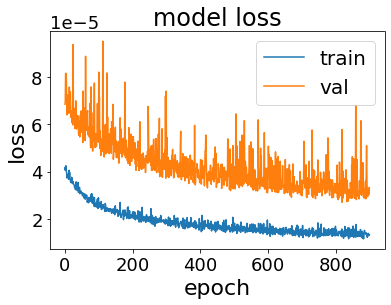

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'][100:])
plt.plot(history.history['val_loss'][100:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])#, loc='upper left')
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

start = time.time()
y_train_pred = reg_best.predict(X_train_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_train, y_train_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_train, y_train_pred)
print('mae: ',mae)

r2_model = r2_score(y_train, y_train_pred)
print('\nR2: ',r2_model)

time =  -2.268496513366699

mse:  9.099983374221703e-06
rmse:  0.003016617870102493
mae:  0.0008450656833952448

R2:  0.993595553920716


In [16]:
start = time.time()
y_test_pred = reg_best.predict(X_test_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_test, y_test_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_test, y_test_pred)
print('mae: ',mae)

r2_model = r2_score(y_test, y_test_pred)
print('\nR2: ',r2_model)

time =  -0.6553816795349121

mse:  1.9480014922996574e-05
rmse:  0.004413616988706267
mae:  0.0009347758620659551

R2:  0.9907594532187982


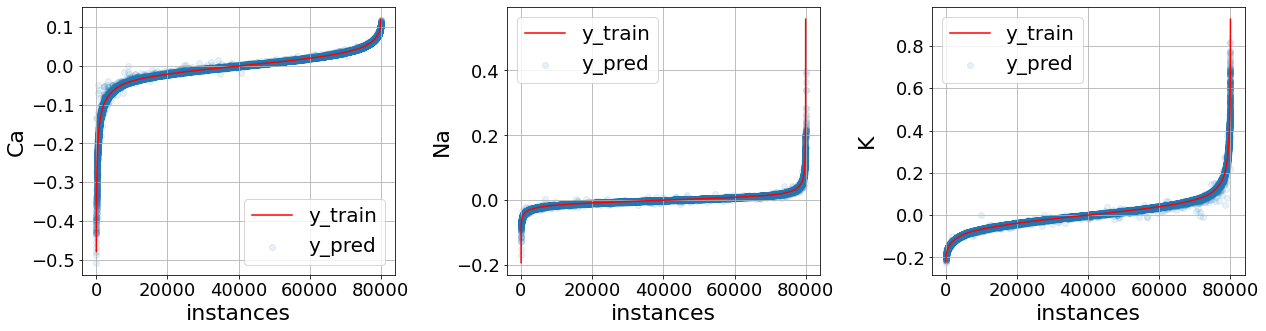

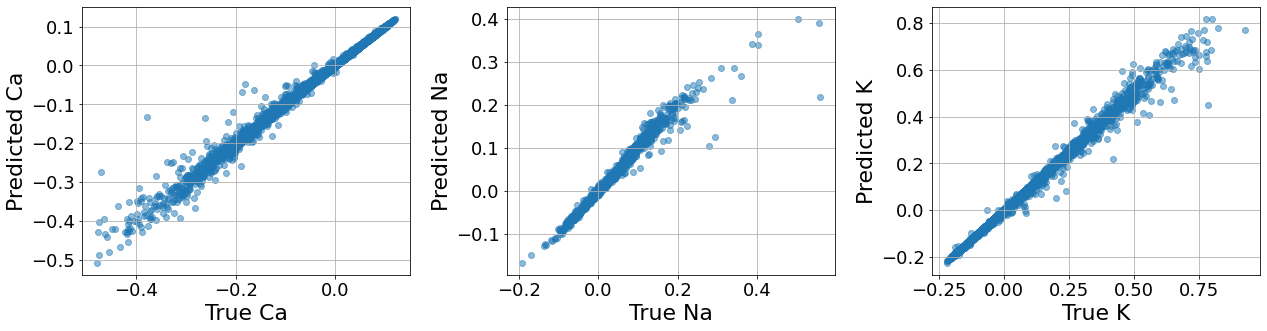

In [17]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)
fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    aux_train = y_train[:,i]
    aux_pred = y_train_pred[:,i]
    index = np.argsort(aux_train)
    x = range(len(index))
    ax.plot(x, aux_train[index], 'r-')
    ax.scatter(x, aux_pred[index], alpha=0.1)
    ax.legend(['y_train', 'y_pred'])
    ax.set_xlabel('instances')
    ax.set_ylabel(outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

print('\n\n')

fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    ax.scatter(y_train[:,i], y_train_pred[:,i], alpha=0.5)
    ax.set_xlabel('True '+outputs[i].split('_')[1])
    ax.set_ylabel('Predicted '+outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

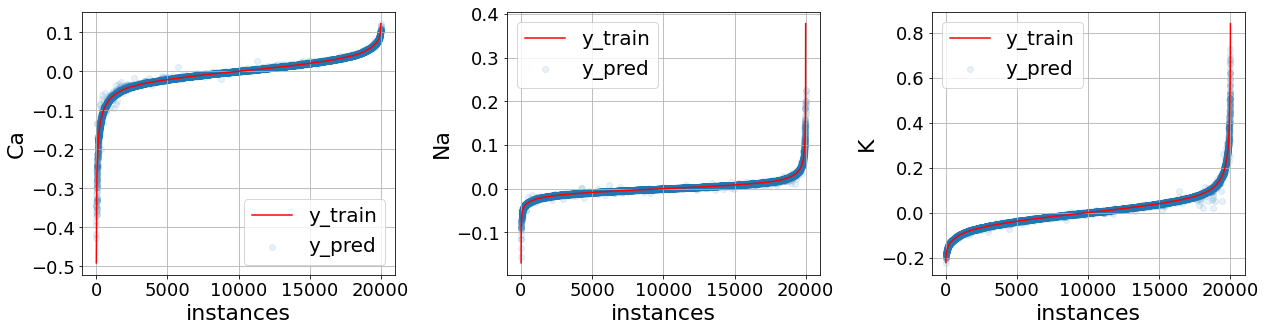

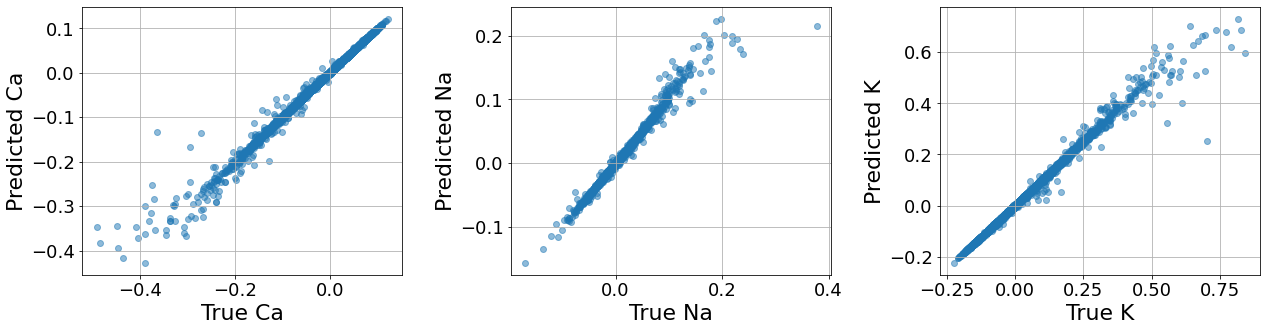

In [18]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)
fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    aux_train = y_test[:,i]
    aux_pred = y_test_pred[:,i]
    index = np.argsort(aux_train)
    x = range(len(index))
    ax.plot(x, aux_train[index], 'r-')
    ax.scatter(x, aux_pred[index], alpha=0.1)
    ax.legend(['y_train', 'y_pred'])
    ax.set_xlabel('instances')
    ax.set_ylabel(outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

print('\n\n')

fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    ax.scatter(y_test[:,i], y_test_pred[:,i], alpha=0.5)
    ax.set_xlabel('True '+outputs[i].split('_')[1])
    ax.set_ylabel('Predicted '+outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

In [21]:
# Add Physics-constrained

#y_test_pred = NNmodel_loaded.predict(norm_pipeline_loaded.transform(X_test))
y_test_pred_con = (y_test_pred.T*(2*X_test[:, 0]+X_test[:, 1]+X_test[:, 2]) \
                         /(2*y_test_pred[:, 0]+y_test_pred[:, 1]+y_test_pred[:, 2])).T
print('rmse: ', np.sqrt(mean_squared_error(y_test, y_test_pred)))

rmse:  0.004413616988706267
